In [13]:
import numpy as np
from google.colab import files

# --- Step 1: Upload the Z-matrix text file ---
uploaded = files.upload()  # Upload one .txt file

# --- Step 2: Convert the text Z-matrix into a 2D Python list ---
def read_raw_zmatrix(content):
    lines = [line.strip().split(',') for line in content.strip().split('\n') if line.strip()]
    return lines

# --- Step 3: Process and Save ---
for filename, file in uploaded.items():
    print(f"\n📂 Processing: {filename}")
    content = file.decode('utf-8')
    zmatrix_list = read_raw_zmatrix(content)

    # Convert to NumPy object array to preserve mixed types
    zmatrix_array = np.array(zmatrix_list, dtype=object)

    # Save to .npy
    base_name = filename.rsplit('.', 1)[0]
    np.save(f"{base_name}.npy", zmatrix_array)

    print(f"✅ Saved: {base_name}.npy")
    print("🔍 Preview (first few rows):")
    for row in zmatrix_array[:5]:
        print(row)


Saving butanone.txt to butanone.txt

📂 Processing: butanone.txt
✅ Saved: butanone.npy
🔍 Preview (first few rows):
['C']
['C', '1', '1.53']
['C', '2', '1.54', '1', '112.60']
['C', '3', '1.54', '2', '115.12', '1', '180.01']
['H', '4', '1.08', '3', '110.21', '2', '180.01']


Saving butanone.npy to butanone (1).npy

📁 Processing file: butanone (1).npy

🔹 Bond Matrix:
 tensor([[0.0000, 1.5300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0800, 1.0800, 1.0800],
        [1.5300, 0.0000, 1.5400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0800,
         1.0800, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.5400, 0.0000, 1.5400, 0.0000, 0.0000, 0.0000, 1.2100, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.5400, 0.0000, 1.0800, 1.0800, 1.0800, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2100, 0.0000, 0.00

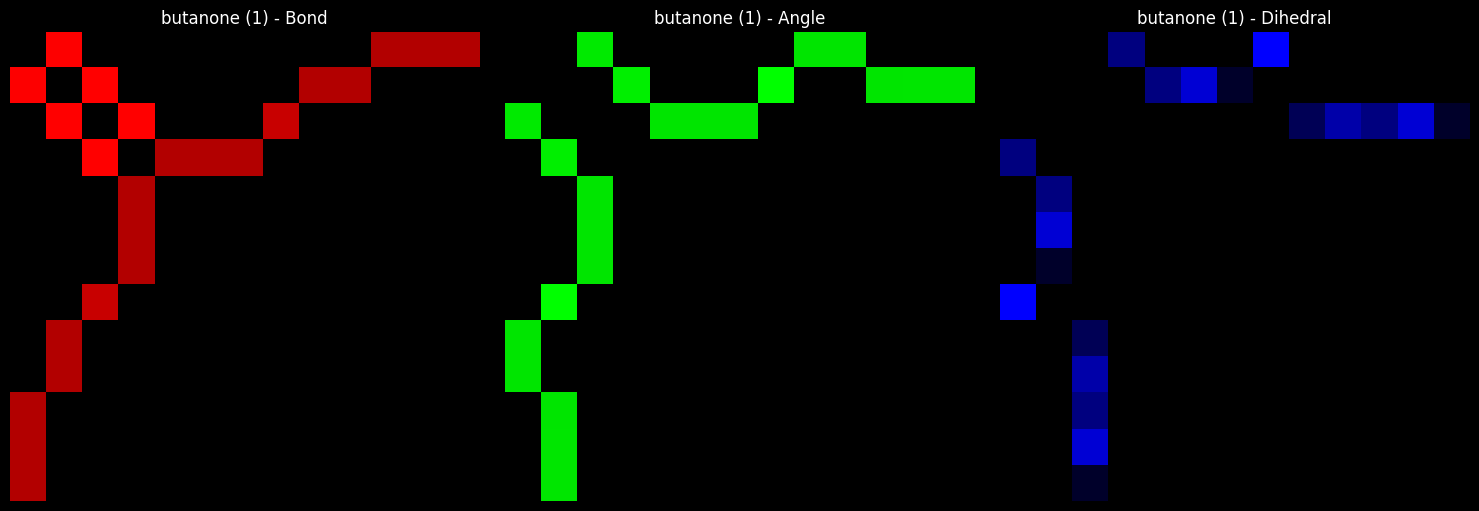

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, PngImagePlugin
from google.colab import files

# --- Upload .npy Z-matrix file ---
uploaded = files.upload()

# --- Function: Split Z-matrix into 3 matrices ---
def split_zmatrix_into_matrices(zmatrix):
    num_atoms = len(zmatrix)
    bond_matrix = np.zeros((num_atoms, num_atoms), dtype=float)
    angle_matrix = np.zeros((num_atoms, num_atoms), dtype=float)
    dihedral_matrix = np.zeros((num_atoms, num_atoms), dtype=float)

    for i, row in enumerate(zmatrix):
        if len(row) >= 3:
            bond_matrix[i][int(row[1]) - 1] = float(row[2])
            bond_matrix[int(row[1]) - 1][i] = float(row[2])
        if len(row) >= 5:
            angle_matrix[i][int(row[3]) - 1] = float(row[4])
            angle_matrix[int(row[3]) - 1][i] = float(row[4])
        if len(row) >= 7:
            dihedral_matrix[i][int(row[5]) - 1] = float(row[6])
            dihedral_matrix[int(row[5]) - 1][i] = float(row[6])

    return bond_matrix, angle_matrix, dihedral_matrix


# --- Function: Create color palette with black background ---
def create_palette(base_color):
    """
    Create a palette where 0 maps to black and 255 maps to the base_color.
    """
    palette = []
    for i in range(256):
        r = int(base_color[0] * (i / 255))
        g = int(base_color[1] * (i / 255))
        b = int(base_color[2] * (i / 255))
        palette.append((r, g, b))
    return palette

red_palette = create_palette((255, 0, 0))     # Bond: red tones on black
green_palette = create_palette((0, 255, 0))   # Angle: green tones on black
blue_palette = create_palette((0, 0, 255))    # Dihedral: blue tones on black


# --- Function: Save matrix as image with metadata ---
def save_matrix_as_image(matrix, output_path, palette, label):
    height, width = matrix.shape
    # Start with black background
    img = Image.new('RGB', (width, height), (0, 0, 0))

    max_val = np.max(matrix) if np.max(matrix) != 0 else 1
    scaled_matrix = ((matrix / max_val) * 255).astype(int)
    scaled_matrix = np.clip(scaled_matrix, 0, 255)

    for i in range(height):
        for j in range(width):
            img.putpixel((j, i), palette[scaled_matrix[i, j]])

    # --- Add matrix metadata ---
    metadata = PngImagePlugin.PngInfo()
    metadata.add_text("MatrixData", ','.join(map(str, matrix.flatten())))
    metadata.add_text("MatrixShape", f"{height},{width}")
    metadata.add_text("Description", f"{label} matrix")

    img.save(output_path, pnginfo=metadata)
    return img


# --- Function: Display image gallery with black background ---
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.patch.set_facecolor("black")  # Figure background
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, color="white")  # White titles for contrast
        ax.axis('off')
        ax.set_facecolor("black")  # Axes background
    plt.tight_layout()
    plt.show()


# --- Main Process ---
for filename in uploaded.keys():
    print(f"\n📁 Processing file: {filename}")
    zmatrix = np.load(filename, allow_pickle=True)

    bond_matrix, angle_matrix, dihedral_matrix = split_zmatrix_into_matrices(zmatrix)

    # Round for cleaner printing
    bond_matrix = np.round(bond_matrix, 2)
    angle_matrix = np.round(angle_matrix, 2)
    dihedral_matrix = np.round(dihedral_matrix, 2)

    print("\n🔹 Bond Matrix:\n", torch.tensor(bond_matrix))
    print("\n🔹 Angle Matrix:\n", torch.tensor(angle_matrix))
    print("\n🔹 Dihedral Matrix:\n", torch.tensor(dihedral_matrix))

    base = os.path.splitext(filename)[0]

    img_bond = save_matrix_as_image(bond_matrix, f"{base}_bond.png", red_palette, "Bond")
    img_angle = save_matrix_as_image(angle_matrix, f"{base}_angle.png", green_palette, "Angle")
    img_dihedral = save_matrix_as_image(dihedral_matrix, f"{base}_dihedral.png", blue_palette, "Dihedral")

    # Show with black background
    show_images([img_bond, img_angle, img_dihedral],
                [f"{base} - Bond", f"{base} - Angle", f"{base} - Dihedral"])

    # Download generated images
    files.download(f"{base}_bond.png")
    files.download(f"{base}_angle.png")
    files.download(f"{base}_dihedral.png")


Upload Bond Matrix Image:


Saving butanone (1)_bond.png to butanone (1)_bond (1).png
Upload Angle Matrix Image:


Saving butanone (1)_angle.png to butanone (1)_angle (1).png
Upload Dihedral Matrix Image:


Saving butanone (1)_dihedral.png to butanone (1)_dihedral (1).png

========= DECODED MATRICES =========

Bond Matrix (Tensor):
tensor([[0.0000, 1.5300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0800, 1.0800, 1.0800],
        [1.5300, 0.0000, 1.5400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0800,
         1.0800, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.5400, 0.0000, 1.5400, 0.0000, 0.0000, 0.0000, 1.2100, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.5400, 0.0000, 1.0800, 1.0800, 1.0800, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0

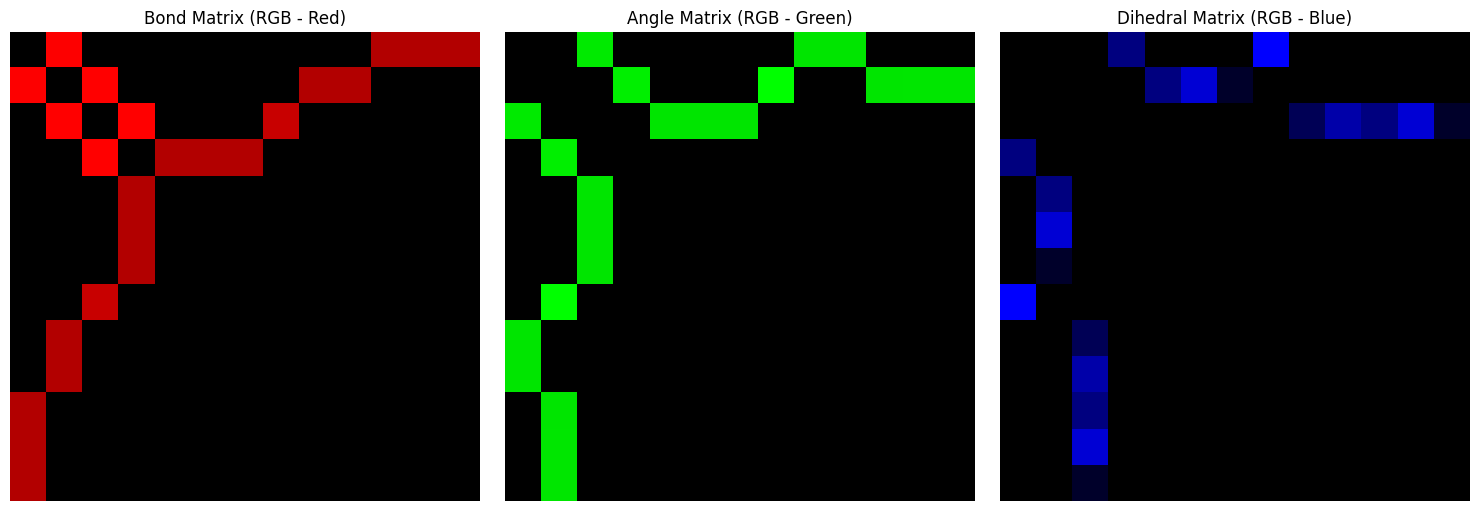

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# --- Step 1: Upload PNG images containing matrix metadata ---
print("Upload Bond Matrix Image:")
bond_upload = files.upload()
bond_image_path = list(bond_upload.keys())[0]

print("Upload Angle Matrix Image:")
angle_upload = files.upload()
angle_image_path = list(angle_upload.keys())[0]

print("Upload Dihedral Matrix Image:")
dihedral_upload = files.upload()
dihedral_image_path = list(dihedral_upload.keys())[0]

# --- Step 2: Load Matrix from Image Metadata ---
def load_matrix_from_image(image_path):
    img = Image.open(image_path)
    meta = img.info
    if "MatrixData" not in meta:
        raise ValueError(f"MatrixData metadata not found in {image_path}.")
    matrix_data = list(map(float, meta["MatrixData"].split(',')))
    N = int(np.sqrt(len(matrix_data)))
    if N * N != len(matrix_data):
        raise ValueError(f"Matrix data length {len(matrix_data)} is not a perfect square.")
    matrix = np.array(matrix_data).reshape((N, N))
    return matrix

# --- Step 3: Convert Matrix to RGB Image ---
def matrix_to_rgb_image(matrix, channel):
    norm = (matrix / np.max(matrix)) if np.max(matrix) != 0 else matrix
    norm = (norm * 255).astype(np.uint8)

    rgb_image = np.zeros((matrix.shape[0], matrix.shape[1], 3), dtype=np.uint8)
    rgb_image[:, :, channel] = norm  # 0=Red, 1=Green, 2=Blue
    return rgb_image

# --- Step 4: Display Tensor and RGB Matrix Images ---
def display_tensor_and_rgb(bond, angle, dihedral):
    print("\n========= DECODED MATRICES =========")
    print("\nBond Matrix (Tensor):")
    print(torch.tensor(bond))
    print("\nAngle Matrix (Tensor):")
    print(torch.tensor(angle))
    print("\nDihedral Matrix (Tensor):")
    print(torch.tensor(dihedral))

    rgb_bond = matrix_to_rgb_image(bond, 0)       # Red
    rgb_angle = matrix_to_rgb_image(angle, 1)     # Green
    rgb_dihedral = matrix_to_rgb_image(dihedral, 2)  # Blue

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_bond)
    plt.title("Bond Matrix (RGB - Red)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_angle)
    plt.title("Angle Matrix (RGB - Green)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_dihedral)
    plt.title("Dihedral Matrix (RGB - Blue)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("======================================")

# --- Step 5: Load, Decode, and Display ---
bond_matrix = load_matrix_from_image(bond_image_path)
angle_matrix = load_matrix_from_image(angle_image_path)
dihedral_matrix = load_matrix_from_image(dihedral_image_path)

display_tensor_and_rgb(bond_matrix, angle_matrix, dihedral_matrix)


Upload Bond Matrix Image:


Saving butanone (1)_bond (1).png to butanone (1)_bond (1) (1).png
Upload Angle Matrix Image:


Saving butanone (1)_angle (1).png to butanone (1)_angle (1) (1).png
Upload Dihedral Matrix Image:


Saving butanone (1)_dihedral (1).png to butanone (1)_dihedral (1) (1).png


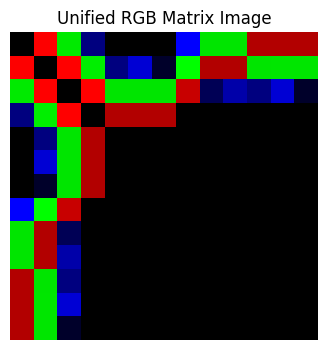

✅ Unified image saved with metadata at: /content/unified_matrix_image.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, PngImagePlugin
from google.colab import files

# --- Step 1: Upload matrix images ---
print("Upload Bond Matrix Image:")
bond_upload = files.upload()
bond_image_path = list(bond_upload.keys())[0]

print("Upload Angle Matrix Image:")
angle_upload = files.upload()
angle_image_path = list(angle_upload.keys())[0]

print("Upload Dihedral Matrix Image:")
dihedral_upload = files.upload()
dihedral_image_path = list(dihedral_upload.keys())[0]

# --- Step 2: Load Matrix from Image Metadata ---
def load_matrix_from_image(image_path):
    img = Image.open(image_path)
    meta = img.info
    if "MatrixData" not in meta:
        raise ValueError(f"❌ MatrixData metadata not found in: {image_path}")
    matrix_data = list(map(float, meta["MatrixData"].split(',')))
    N = int(np.sqrt(len(matrix_data)))
    if N * N != len(matrix_data):
        raise ValueError(f"❌ Matrix data in {image_path} is not a perfect square.")
    matrix = np.array(matrix_data).reshape((N, N))
    return matrix

# --- Step 3: Decode matrices ---
bond_matrix = load_matrix_from_image(bond_image_path)
angle_matrix = load_matrix_from_image(angle_image_path)
dihedral_matrix = load_matrix_from_image(dihedral_image_path)

# --- Step 4: Create unified RGB image ---
def create_unified_image(bond, angle, dihedral):
    if not (bond.shape == angle.shape == dihedral.shape):
        raise ValueError("❌ Matrix shape mismatch. Ensure all matrices have same dimensions.")

    # Normalize each matrix safely
    def safe_normalize(mat):
        max_val = np.max(mat)
        return mat / max_val if max_val != 0 else mat

    bond_norm = safe_normalize(bond)
    angle_norm = safe_normalize(angle)
    dihedral_norm = safe_normalize(dihedral)

    rgb_image = np.stack([bond_norm, angle_norm, dihedral_norm], axis=-1)
    rgb_image_uint8 = (rgb_image * 255).astype(np.uint8)
    return rgb_image_uint8

unified_image_array = create_unified_image(bond_matrix, angle_matrix, dihedral_matrix)
unified_image = Image.fromarray(unified_image_array)

# --- Step 5: Display unified image safely ---
if unified_image_array.size == 0 or unified_image_array.shape[-1] != 3:
    raise ValueError("❌ Unified image array is invalid.")
plt.figure(figsize=(4, 4))
plt.imshow(unified_image_array)
plt.axis('off')
plt.title("Unified RGB Matrix Image")
plt.show()

# --- Step 6: Save unified image with metadata ---
meta = PngImagePlugin.PngInfo()
meta.add_text("MatrixData", ';'.join([
    ','.join(map(str, bond_matrix.flatten())),
    ','.join(map(str, angle_matrix.flatten())),
    ','.join(map(str, dihedral_matrix.flatten()))
]))

unified_image_path = "/content/unified_matrix_image.png"
unified_image.save(unified_image_path, pnginfo=meta)
print(f"✅ Unified image saved with metadata at: {unified_image_path}")
files.download(unified_image_path)

# --- Step 7: Reload image and extract matrices ---
def extract_matrices_from_unified_image(image_path):
    img = Image.open(image_path)
    meta = img.info
    if "MatrixData" not in meta:
        raise ValueError("❌ Metadata missing in unified image.")

    bond_str, angle_str, dihedral_str = meta["MatrixData"].split(";")
    bond = np.array(list(map(float, bond_str.split(','))))
    angle = np.array(list(map(float, angle_str.split(','))))
    dihedral = np.array(list(map(float, dihedral_str.split(','))))

    N = int(np.sqrt(len(bond)))
    return bond.reshape(N, N), angle.reshape(N, N), dihedral.reshape(N, N)

# Optional reload check (no print)
bond_decoded, angle_decoded, dihedral_decoded = extract_matrices_from_unified_image(unified_image_path)


Upload the unified image (with metadata):


Saving unified_matrix_image.png to unified_matrix_image (1).png


/tmp/ipython-input-440867868.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image_array, mode='L')


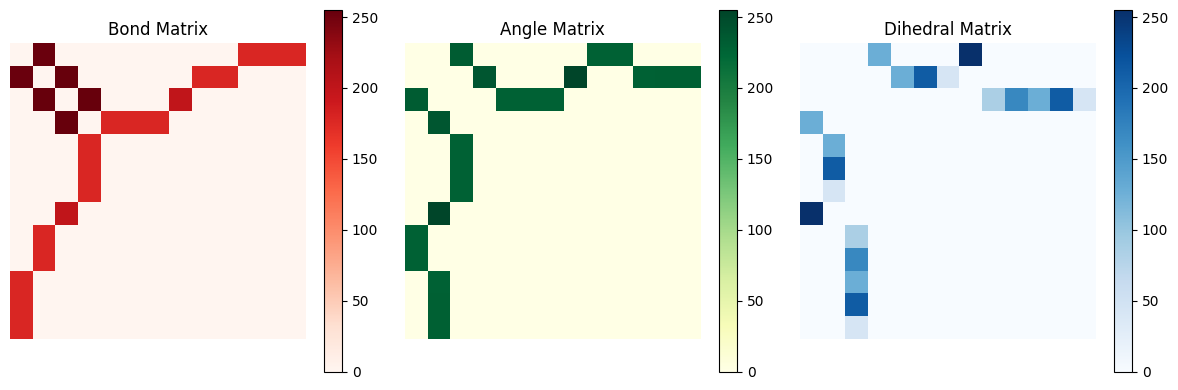

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from PIL import Image, PngImagePlugin
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- Step 1: Upload the unified image ---
print("Upload the unified image (with metadata):")
uploaded = files.upload()
unified_image_path = list(uploaded.keys())[0]

# --- Step 2: Extract matrices from unified image metadata ---
def extract_matrices_from_unified_image(image_path):
    img = Image.open(image_path)
    meta = img.info
    if "MatrixData" not in meta:
        raise ValueError("MatrixData metadata not found.")

    bond_str, angle_str, dihedral_str = meta["MatrixData"].split(";")

    bond_matrix = np.array(list(map(float, bond_str.split(','))))
    angle_matrix = np.array(list(map(float, angle_str.split(','))))
    dihedral_matrix = np.array(list(map(float, dihedral_str.split(','))))

    N = int(np.sqrt(len(bond_matrix)))
    bond_matrix = bond_matrix.reshape((N, N))
    angle_matrix = angle_matrix.reshape((N, N))
    dihedral_matrix = dihedral_matrix.reshape((N, N))

    return bond_matrix, angle_matrix, dihedral_matrix

# --- Step 3: Save matrix image with metadata ---
def save_matrix_image(matrix, filename):
    norm_matrix = matrix / np.max(matrix) if np.max(matrix) != 0 else matrix
    image_array = (norm_matrix * 255).astype(np.uint8)
    img = Image.fromarray(image_array, mode='L')

    meta = PngImagePlugin.PngInfo()
    meta.add_text("MatrixData", ','.join(map(str, matrix.flatten())))
    img.save(filename, pnginfo=meta)
    return image_array

# --- Step 4: Extract and save each matrix ---
bond_matrix, angle_matrix, dihedral_matrix = extract_matrices_from_unified_image(unified_image_path)

bond_img_array = save_matrix_image(bond_matrix, "/content/bond_matrix_extracted.png")
angle_img_array = save_matrix_image(angle_matrix, "/content/angle_matrix_extracted.png")
dihedral_img_array = save_matrix_image(dihedral_matrix, "/content/dihedral_matrix_extracted.png")

# --- Step 5: Display all three images horizontally ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(bond_img_array, cmap='Reds')
plt.title("Bond Matrix")
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(angle_img_array, cmap='YlGn')
plt.title("Angle Matrix")
plt.axis('off')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(dihedral_img_array, cmap='Blues')
plt.title("Dihedral Matrix")
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

# --- Step 6: Download the images ---
files.download("/content/bond_matrix_extracted.png")
files.download("/content/angle_matrix_extracted.png")
files.download("/content/dihedral_matrix_extracted.png")


In [18]:
import numpy as np
from PIL import Image
from google.colab import files

# --- Function to decode matrix from metadata ---
def load_matrix_from_image(image_path):
    img = Image.open(image_path)
    meta = img.info
    if "MatrixData" not in meta:
        raise ValueError("MatrixData metadata not found in image.")
    matrix_data = list(map(float, meta["MatrixData"].split(',')))
    N = int(np.sqrt(len(matrix_data)))
    if N * N != len(matrix_data):
        raise ValueError(f"Matrix data length {len(matrix_data)} is not a perfect square.")
    matrix = np.array(matrix_data).reshape((N, N))
    return matrix

# --- Upload the three images ---
print("Upload bond_matrix image:")
bond_upload = files.upload()
bond_image_path = list(bond_upload.keys())[0]

print("Upload angle_matrix image:")
angle_upload = files.upload()
angle_image_path = list(angle_upload.keys())[0]

print("Upload dihedral_matrix image:")
dihedral_upload = files.upload()
dihedral_image_path = list(dihedral_upload.keys())[0]

# --- Decode matrices using the function ---
bond_matrix = load_matrix_from_image(bond_image_path)
angle_matrix = load_matrix_from_image(angle_image_path)
dihedral_matrix = load_matrix_from_image(dihedral_image_path)

# --- Display the decoded matrices ---
print("\n========= DECODED MATRICES =========")
print("\nBond Length Matrix:")
print(bond_matrix)

print("\nAngle Matrix:")
print(angle_matrix)

print("\nDihedral Matrix:")
print(dihedral_matrix)

# --- Save matrices to .npy files ---
np.save("bond_matrix.npy", bond_matrix)
np.save("angle_matrix.npy", angle_matrix)
np.save("dihedral_matrix.npy", dihedral_matrix)
print("\n✅ Matrices saved as 'bond_matrix.npy', 'angle_matrix.npy', and 'dihedral_matrix.npy'")


Upload bond_matrix image:


Saving bond_matrix_extracted.png to bond_matrix_extracted (1).png
Upload angle_matrix image:


Saving angle_matrix_extracted.png to angle_matrix_extracted (1).png
Upload dihedral_matrix image:


Saving dihedral_matrix_extracted.png to dihedral_matrix_extracted (1).png

========= DECODED MATRICES =========

Bond Length Matrix:
[[0.   1.53 0.   0.   0.   0.   0.   0.   0.   0.   1.08 1.08 1.08]
 [1.53 0.   1.54 0.   0.   0.   0.   0.   1.08 1.08 0.   0.   0.  ]
 [0.   1.54 0.   1.54 0.   0.   0.   1.21 0.   0.   0.   0.   0.  ]
 [0.   0.   1.54 0.   1.08 1.08 1.08 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.21 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.08 0.   0.   0.   0.   0.   0.   0.   0.   0.  